# Transition State Search (NEBs)

FAIR chemistry models can be used to enumerate and study reaction pathways via transition state search tools built into ASE or in packages like Sella via the ASE interface.

The first section of this tutorial walks through how to use the CatTsunami tools to automatically enumerate a number of hypothetical initial/final configurations for various types of reactions on a heterogeneous catalyst surface. If you already have a NEB you're looking to optimize, you can jump straight to the last section (Run NEBs)!

Since the NEB calculations here can be a bit time consuming, we'll use a small number of steps during the documentation testing, and otherwise use a reasonable guess.

In [1]:
import os

# Use a small number of steps here to keep the docs fast during CI, but otherwise do quite reasonable settings.
fast_docs = os.environ.get("FAST_DOCS", "false").lower() == "true"
if fast_docs:
    optimization_steps = 20
else:
    optimization_steps = 300

````{admonition} Need to install fairchem-core or get UMA access or getting permissions/401 errors?
:class: dropdown


1. Install the necessary packages using pip, uv etc
```{code-cell} ipython3
:tags: [skip-execution]

! pip install fairchem-core fairchem-data-oc fairchem-applications-cattsunami
```

2. Get access to any necessary huggingface gated models
    * Get and login to your Huggingface account
    * Request access to https://huggingface.co/facebook/UMA
    * Create a Huggingface token at https://huggingface.co/settings/tokens/ with the permission "Permissions: Read access to contents of all public gated repos you can access"
    * Add the token as an environment variable using `huggingface-cli login` or by setting the HF_TOKEN environment variable.

```{code-cell} ipython3
:tags: [skip-execution]

# Login using the huggingface-cli utility
! huggingface-cli login

# alternatively,
import os
os.environ['HF_TOKEN'] = 'MY_TOKEN'
```

````

## Do enumerations in an AdsorbML style

In [2]:
from __future__ import annotations

import matplotlib.pyplot as plt
from ase.io import read
from ase.mep import DyNEB
from ase.optimize import BFGS
from fairchem.applications.cattsunami.core import Reaction
from fairchem.applications.cattsunami.core.autoframe import AutoFrameDissociation
from fairchem.applications.cattsunami.databases import DISSOCIATION_REACTION_DB_PATH
from fairchem.core import FAIRChemCalculator, pretrained_mlip
from fairchem.data.oc.core import Adsorbate, AdsorbateSlabConfig, Bulk, Slab
from fairchem.data.oc.databases.pkls import ADSORBATE_PKL_PATH, BULK_PKL_PATH
from x3dase.x3d import X3D

# Instantiate the reaction class for the reaction of interest
reaction = Reaction(
    reaction_str_from_db="*CH -> *C + *H",
    reaction_db_path=DISSOCIATION_REACTION_DB_PATH,
    adsorbate_db_path=ADSORBATE_PKL_PATH,
)

In [3]:
# Instantiate our adsorbate class for the reactant and product
reactant = Adsorbate(
    adsorbate_id_from_db=reaction.reactant1_idx, adsorbate_db_path=ADSORBATE_PKL_PATH
)
product1 = Adsorbate(
    adsorbate_id_from_db=reaction.product1_idx, adsorbate_db_path=ADSORBATE_PKL_PATH
)
product2 = Adsorbate(
    adsorbate_id_from_db=reaction.product2_idx, adsorbate_db_path=ADSORBATE_PKL_PATH
)

In [4]:
# Grab the bulk and cut the slab we are interested in
bulk = Bulk(bulk_src_id_from_db="mp-33", bulk_db_path=BULK_PKL_PATH)
slab = Slab.from_bulk_get_specific_millers(bulk=bulk, specific_millers=(0, 0, 1))

In [5]:
# Perform site enumeration
# For AdsorbML num_sites = 100, but we use 5 here for brevity. This should be increased for practical use.
reactant_configs = AdsorbateSlabConfig(
    slab=slab[0],
    adsorbate=reactant,
    mode="random_site_heuristic_placement",
    num_sites=10,
).atoms_list
product1_configs = AdsorbateSlabConfig(
    slab=slab[0],
    adsorbate=product1,
    mode="random_site_heuristic_placement",
    num_sites=10,
).atoms_list
product2_configs = AdsorbateSlabConfig(
    slab=slab[0],
    adsorbate=product2,
    mode="random_site_heuristic_placement",
    num_sites=10,
).atoms_list

In [6]:
# Instantiate the calculator
predictor = pretrained_mlip.get_predict_unit("uma-s-1p1")
calc = FAIRChemCalculator(predictor, task_name="oc20")

In [7]:
# Relax the reactant systems
reactant_energies = []
for config in reactant_configs:
    config.calc = calc
    config.pbc = True
    opt = BFGS(config)
    opt.run(fmax=0.05, steps=optimization_steps)
    reactant_energies.append(config.get_potential_energy())

      Step     Time          Energy          fmax
BFGS:    0 01:00:16     -300.859344        4.017380
BFGS:    1 01:00:16     -301.262566        3.431521
BFGS:    2 01:00:17     -302.461237        3.470676


BFGS:    3 01:00:17     -302.101680       10.170259
BFGS:    4 01:00:17     -302.765141        2.933927
BFGS:    5 01:00:17     -302.914391        2.176763


BFGS:    6 01:00:17     -303.055876        2.062817
BFGS:    7 01:00:17     -303.098210        0.698727
BFGS:    8 01:00:17     -303.119625        0.569117


BFGS:    9 01:00:17     -303.177848        0.949690
BFGS:   10 01:00:17     -303.188323        0.501531
BFGS:   11 01:00:17     -303.195197        0.186671


BFGS:   12 01:00:17     -303.196871        0.234474
BFGS:   13 01:00:17     -303.201666        0.282703
BFGS:   14 01:00:18     -303.204409        0.223803


BFGS:   15 01:00:18     -303.206264        0.158199
BFGS:   16 01:00:18     -303.207408        0.145800
BFGS:   17 01:00:18     -303.209067        0.154001


BFGS:   18 01:00:18     -303.212275        0.215023
BFGS:   19 01:00:18     -303.217735        0.269128
BFGS:   20 01:00:18     -303.223140        0.244904


      Step     Time          Energy          fmax
BFGS:    0 01:00:18     -300.717998        3.938132
BFGS:    1 01:00:18     -301.170197        3.850771
BFGS:    2 01:00:18     -302.564870        3.643493


BFGS:    3 01:00:18     -302.360188        8.625868
BFGS:    4 01:00:18     -302.824594        3.244900
BFGS:    5 01:00:19     -302.971294        2.552340


BFGS:    6 01:00:19     -303.091903        2.544698
BFGS:    7 01:00:19     -303.135838        0.618489
BFGS:    8 01:00:19     -303.142568        0.364653


BFGS:    9 01:00:19     -303.149881        0.349633
BFGS:   10 01:00:19     -303.156661        0.471152
BFGS:   11 01:00:19     -303.168421        0.482936


BFGS:   12 01:00:19     -303.174007        0.325303
BFGS:   13 01:00:19     -303.176945        0.201169
BFGS:   14 01:00:19     -303.185095        0.239524


BFGS:   15 01:00:19     -303.191264        0.314923
BFGS:   16 01:00:19     -303.198039        0.257160


BFGS:   17 01:00:20     -303.200836        0.114694
BFGS:   18 01:00:20     -303.201622        0.065734
BFGS:   19 01:00:20     -303.202074        0.066086


BFGS:   20 01:00:20     -303.203168        0.139985
      Step     Time          Energy          fmax
BFGS:    0 01:00:20     -301.346084        4.131979
BFGS:    1 01:00:20     -301.728836        3.219916


BFGS:    2 01:00:20     -302.718210        3.433740
BFGS:    3 01:00:20     -302.838520        3.412150
BFGS:    4 01:00:20     -303.103982        2.289531


BFGS:    5 01:00:20     -303.217102        3.491136
BFGS:    6 01:00:21     -303.313119        1.287950
BFGS:    7 01:00:21     -303.393800        1.090469


BFGS:    8 01:00:21     -303.771899        1.573097
BFGS:    9 01:00:21     -303.779960        2.367720
BFGS:   10 01:00:21     -303.906202        1.345139


BFGS:   11 01:00:21     -303.954882        0.998108
BFGS:   12 01:00:21     -304.081805        1.148062
BFGS:   13 01:00:21     -304.109603        0.775577


BFGS:   14 01:00:21     -304.156613        0.471136
BFGS:   15 01:00:21     -304.173326        0.351742
BFGS:   16 01:00:21     -304.205025        0.523870


BFGS:   17 01:00:21     -304.236134        0.675918
BFGS:   18 01:00:22     -304.271130        0.786003
BFGS:   19 01:00:22     -304.303798        0.863970


BFGS:   20 01:00:22     -304.358991        0.822802
      Step     Time          Energy          fmax
BFGS:    0 01:00:22     -301.029383        4.043729
BFGS:    1 01:00:22     -301.423720        3.444711


BFGS:    2 01:00:22     -302.555336        3.377754
BFGS:    3 01:00:22     -302.399580        7.840480
BFGS:    4 01:00:22     -302.872134        2.752912


BFGS:    5 01:00:22     -303.014611        1.801133
BFGS:    6 01:00:22     -303.121765        1.868879
BFGS:    7 01:00:22     -303.154369        0.813425


BFGS:    8 01:00:22     -303.200114        1.036554
BFGS:    9 01:00:23     -303.253745        1.192009
BFGS:   10 01:00:23     -303.294851        1.126932


BFGS:   11 01:00:23     -303.339950        0.829619
BFGS:   12 01:00:23     -303.410910        1.273032
BFGS:   13 01:00:23     -303.525253        2.073045


BFGS:   14 01:00:23     -303.617177        2.546590
BFGS:   15 01:00:23     -303.727825        3.234702
BFGS:   16 01:00:23     -303.896409        1.346659


BFGS:   17 01:00:23     -303.971170        1.342949
BFGS:   18 01:00:23     -304.012531        1.599458
BFGS:   19 01:00:23     -304.066134        1.145422


BFGS:   20 01:00:23     -304.103370        0.762784
      Step     Time          Energy          fmax
BFGS:    0 01:00:24     -302.211719        4.003414
BFGS:    1 01:00:24     -302.577161        3.203485


BFGS:    2 01:00:24     -303.451776        3.019646
BFGS:    3 01:00:24     -303.596690        2.744556
BFGS:    4 01:00:24     -303.859285        1.930114


BFGS:    5 01:00:24     -303.971569        2.102702
BFGS:    6 01:00:24     -304.061669        1.680328
BFGS:    7 01:00:24     -304.174052        0.683990


BFGS:    8 01:00:24     -304.197810        0.740135
BFGS:    9 01:00:24     -304.258593        0.640476
BFGS:   10 01:00:24     -304.281196        0.343255


BFGS:   11 01:00:24     -304.290419        0.320763
BFGS:   12 01:00:24     -304.297488        0.389970
BFGS:   13 01:00:25     -304.310101        0.433174


BFGS:   14 01:00:25     -304.322521        0.353635
BFGS:   15 01:00:25     -304.330303        0.235151
BFGS:   16 01:00:25     -304.335101        0.181597


BFGS:   17 01:00:25     -304.340548        0.179483
BFGS:   18 01:00:25     -304.345612        0.226096
BFGS:   19 01:00:25     -304.350621        0.228886


BFGS:   20 01:00:25     -304.353834        0.142932
      Step     Time          Energy          fmax
BFGS:    0 01:00:25     -301.772065        4.057139
BFGS:    1 01:00:25     -302.147419        3.304809


BFGS:    2 01:00:25     -303.133995        3.217599
BFGS:    3 01:00:25     -303.300288        4.279127
BFGS:    4 01:00:26     -303.595942        2.281911


BFGS:    5 01:00:26     -303.883932        2.524809
BFGS:    6 01:00:26     -303.975416        1.467433
BFGS:    7 01:00:26     -304.069357        1.169042


BFGS:    8 01:00:26     -304.108488        0.849672
BFGS:    9 01:00:26     -304.145609        0.730685
BFGS:   10 01:00:26     -304.182524        0.573966


BFGS:   11 01:00:26     -304.203834        0.619737
BFGS:   12 01:00:26     -304.218153        0.377147
BFGS:   13 01:00:26     -304.223411        0.306285


BFGS:   14 01:00:26     -304.230061        0.407158
BFGS:   15 01:00:26     -304.240279        0.564179
BFGS:   16 01:00:27     -304.251014        0.580431


BFGS:   17 01:00:27     -304.260023        0.408865
BFGS:   18 01:00:27     -304.270822        0.448382
BFGS:   19 01:00:27     -304.283395        0.587408


BFGS:   20 01:00:27     -304.299782        0.522233
      Step     Time          Energy          fmax
BFGS:    0 01:00:27     -301.590669        4.160592
BFGS:    1 01:00:27     -301.983658        3.328773


BFGS:    2 01:00:27     -302.995663        3.301516
BFGS:    3 01:00:27     -303.144797        4.174288
BFGS:    4 01:00:27     -303.442067        2.386230


BFGS:    5 01:00:27     -303.716495        3.142452
BFGS:    6 01:00:27     -303.818680        1.705991
BFGS:    7 01:00:28     -303.939550        1.262630


BFGS:    8 01:00:28     -303.982729        0.854867
BFGS:    9 01:00:28     -304.033769        0.784251
BFGS:   10 01:00:28     -304.081597        0.686765


BFGS:   11 01:00:28     -304.117580        0.833978
BFGS:   12 01:00:28     -304.145789        0.562113
BFGS:   13 01:00:28     -304.156423        0.208521


BFGS:   14 01:00:28     -304.159886        0.200882
BFGS:   15 01:00:28     -304.163678        0.200440
BFGS:   16 01:00:28     -304.166326        0.176663


BFGS:   17 01:00:28     -304.167734        0.107814
BFGS:   18 01:00:28     -304.168418        0.077804
BFGS:   19 01:00:29     -304.169122        0.098695


BFGS:   20 01:00:29     -304.170009        0.114604
      Step     Time          Energy          fmax
BFGS:    0 01:00:29     -300.624770        3.921127
BFGS:    1 01:00:29     -301.028076        3.726523


BFGS:    2 01:00:29     -302.255766        3.425421
BFGS:    3 01:00:29     -301.549462       12.204084
BFGS:    4 01:00:29     -302.422330        3.424765


BFGS:    5 01:00:29     -302.502896        3.325812
BFGS:    6 01:00:29     -302.769886        2.917108
BFGS:    7 01:00:29     -302.833323        2.081625


BFGS:    8 01:00:29     -302.944776        1.690454
BFGS:    9 01:00:29     -303.016829        1.974267
BFGS:   10 01:00:30     -303.132569        1.465910


BFGS:   11 01:00:30     -303.174750        0.437663
BFGS:   12 01:00:30     -303.179002        0.238340
BFGS:   13 01:00:30     -303.181557        0.208743


BFGS:   14 01:00:30     -303.184133        0.233183
BFGS:   15 01:00:30     -303.187121        0.192526
BFGS:   16 01:00:30     -303.188538        0.082888


BFGS:   17 01:00:30     -303.188806        0.059837
BFGS:   18 01:00:30     -303.189004        0.054265
BFGS:   19 01:00:30     -303.189261        0.081196


BFGS:   20 01:00:30     -303.189524        0.093857
      Step     Time          Energy          fmax
BFGS:    0 01:00:30     -300.927626        4.055970
BFGS:    1 01:00:31     -301.334266        3.218660


BFGS:    2 01:00:31     -302.507016        3.650432
BFGS:    3 01:00:31     -302.513858        6.277529
BFGS:    4 01:00:31     -302.877981        2.719129


BFGS:    5 01:00:31     -303.054946        1.389327
BFGS:    6 01:00:31     -303.085538        1.053979
BFGS:    7 01:00:31     -303.121954        1.023689


BFGS:    8 01:00:31     -303.144863        1.029332
BFGS:    9 01:00:31     -303.190640        0.403812
BFGS:   10 01:00:31     -303.193700        0.163071


BFGS:   11 01:00:31     -303.195233        0.195589
BFGS:   12 01:00:31     -303.200095        0.310212
BFGS:   13 01:00:32     -303.203121        0.270140


BFGS:   14 01:00:32     -303.205232        0.180934
BFGS:   15 01:00:32     -303.206428        0.147460
BFGS:   16 01:00:32     -303.208902        0.283186


BFGS:   17 01:00:32     -303.212766        0.393928
BFGS:   18 01:00:32     -303.220012        0.401773
BFGS:   19 01:00:32     -303.229814        0.347338


BFGS:   20 01:00:32     -303.262424        1.184153
      Step     Time          Energy          fmax
BFGS:    0 01:00:32     -300.848878        3.943304
BFGS:    1 01:00:32     -301.274929        3.571316


BFGS:    2 01:00:32     -302.579990        3.654136
BFGS:    3 01:00:32     -302.493053        7.456932
BFGS:    4 01:00:32     -302.903843        2.930058


BFGS:    5 01:00:33     -303.072117        1.507767
BFGS:    6 01:00:33     -303.123566        1.435350
BFGS:    7 01:00:33     -303.138013        0.550969


BFGS:    8 01:00:33     -303.146856        0.490989
BFGS:    9 01:00:33     -303.157743        0.692142
BFGS:   10 01:00:33     -303.175428        0.681219


BFGS:   11 01:00:33     -303.184744        0.404511
BFGS:   12 01:00:33     -303.188896        0.192576
BFGS:   13 01:00:33     -303.194632        0.516351


BFGS:   14 01:00:33     -303.202085        0.765993
BFGS:   15 01:00:33     -303.213368        0.811620
BFGS:   16 01:00:33     -303.222497        0.552967


BFGS:   17 01:00:34     -303.227756        0.306511
BFGS:   18 01:00:34     -303.233402        0.482073
BFGS:   19 01:00:34     -303.243049        0.925140


BFGS:   20 01:00:34     -303.295605        2.436120


In [8]:
# Relax the product systems
product1_energies = []
for config in product1_configs:
    config.calc = calc
    config.pbc = True
    opt = BFGS(config)
    opt.run(fmax=0.05, steps=optimization_steps)
    product1_energies.append(config.get_potential_energy())

      Step     Time          Energy          fmax
BFGS:    0 01:00:34     -296.902659        4.574606
BFGS:    1 01:00:34     -297.375555        4.766685


BFGS:    2 01:00:34     -298.680653        3.837524


BFGS:    3 01:00:34     -299.020416        4.720479
BFGS:    4 01:00:34     -299.231116        1.941676


BFGS:    5 01:00:34     -299.405056        1.945370


BFGS:    6 01:00:34     -299.778193        0.871765
BFGS:    7 01:00:34     -299.811796        1.350045


BFGS:    8 01:00:35     -299.860440        0.961402


BFGS:    9 01:00:35     -300.029562        1.077310
BFGS:   10 01:00:35     -300.070981        1.045949


BFGS:   11 01:00:35     -300.217077        1.897037


BFGS:   12 01:00:35     -300.289433        1.941237
BFGS:   13 01:00:35     -300.386193        1.797246


BFGS:   14 01:00:35     -300.474543        0.969573


BFGS:   15 01:00:35     -300.514145        0.848721
BFGS:   16 01:00:35     -300.542473        0.570483


BFGS:   17 01:00:35     -300.560441        0.572541


BFGS:   18 01:00:35     -300.601310        0.303900
BFGS:   19 01:00:35     -300.610715        0.224127


BFGS:   20 01:00:36     -300.614529        0.170530


      Step     Time          Energy          fmax
BFGS:    0 01:00:36     -296.954943        4.573160
BFGS:    1 01:00:36     -297.431769        4.758428


BFGS:    2 01:00:36     -298.732973        3.810764


BFGS:    3 01:00:36     -299.087122        4.522206
BFGS:    4 01:00:36     -299.287886        1.850701


BFGS:    5 01:00:36     -299.462598        1.804984


BFGS:    6 01:00:36     -299.766808        0.939053
BFGS:    7 01:00:36     -299.793182        0.847412


BFGS:    8 01:00:36     -299.924966        0.890029


BFGS:    9 01:00:36     -299.952349        0.651463
BFGS:   10 01:00:36     -299.999171        0.907577


BFGS:   11 01:00:37     -300.023698        1.132749


BFGS:   12 01:00:37     -300.136178        1.844410
BFGS:   13 01:00:37     -300.028621        2.361718


BFGS:   14 01:00:37     -300.229191        1.684374


BFGS:   15 01:00:37     -300.286228        1.349653
BFGS:   16 01:00:37     -300.443022        0.814275


BFGS:   17 01:00:37     -300.492381        0.793465


BFGS:   18 01:00:37     -300.547094        0.541201
BFGS:   19 01:00:37     -300.576357        0.393060


BFGS:   20 01:00:37     -300.590388        0.319000


      Step     Time          Energy          fmax
BFGS:    0 01:00:37     -296.652391        4.473046
BFGS:    1 01:00:37     -297.123157        4.671236


BFGS:    2 01:00:38     -298.471048        3.534049


BFGS:    3 01:00:38     -298.438359        7.217375
BFGS:    4 01:00:38     -298.832171        1.966340


BFGS:    5 01:00:38     -298.927709        1.642569


BFGS:    6 01:00:38     -299.256560        2.400566
BFGS:    7 01:00:38     -299.513002        2.526047


BFGS:    8 01:00:38     -299.545506        2.241454


BFGS:    9 01:00:38     -299.708010        1.191374
BFGS:   10 01:00:38     -299.784744        0.807478


BFGS:   11 01:00:38     -299.869523        0.772913


BFGS:   12 01:00:38     -299.897980        0.721166
BFGS:   13 01:00:38     -299.919449        0.562449


BFGS:   14 01:00:39     -299.935957        0.432464


BFGS:   15 01:00:39     -299.948528        0.410638
BFGS:   16 01:00:39     -299.961132        0.478765


BFGS:   17 01:00:39     -299.974759        0.480504


BFGS:   18 01:00:39     -299.982520        0.394687
BFGS:   19 01:00:39     -299.990652        0.352094


BFGS:   20 01:00:39     -300.006425        0.590552


      Step     Time          Energy          fmax
BFGS:    0 01:00:39     -297.185657        4.549267
BFGS:    1 01:00:39     -297.661825        4.675720


BFGS:    2 01:00:39     -298.931017        3.528403


BFGS:    3 01:00:39     -299.142807        4.981980
BFGS:    4 01:00:39     -299.378019        1.694449


BFGS:    5 01:00:40     -299.492674        1.519984


BFGS:    6 01:00:40     -299.738557        1.534437
BFGS:    7 01:00:40     -299.774188        0.912082


BFGS:    8 01:00:40     -299.839982        1.071715


BFGS:    9 01:00:40     -299.900234        1.168749
BFGS:   10 01:00:40     -299.950254        0.892885


BFGS:   11 01:00:40     -299.984244        0.576387


BFGS:   12 01:00:40     -299.995501        0.396592
BFGS:   13 01:00:40     -300.002052        0.459894


BFGS:   14 01:00:40     -300.015549        0.546934


BFGS:   15 01:00:40     -300.030409        0.479397
BFGS:   16 01:00:40     -300.041631        0.296026


BFGS:   17 01:00:41     -300.050339        0.306578


BFGS:   18 01:00:41     -300.061234        0.308912
BFGS:   19 01:00:41     -300.068896        0.217362


BFGS:   20 01:00:41     -300.073911        0.194172


      Step     Time          Energy          fmax
BFGS:    0 01:00:41     -297.031616        4.604831
BFGS:    1 01:00:41     -297.512617        4.779325


BFGS:    2 01:00:41     -298.796260        3.834380


BFGS:    3 01:00:41     -299.209457        3.959513
BFGS:    4 01:00:41     -299.383924        1.707692


BFGS:    5 01:00:41     -299.593903        1.609323


BFGS:    6 01:00:41     -299.780985        1.350240
BFGS:    7 01:00:41     -299.816839        0.736289


BFGS:    8 01:00:42     -299.848538        0.717187


BFGS:    9 01:00:42     -299.963792        0.858513
BFGS:   10 01:00:42     -299.987116        0.736736


BFGS:   11 01:00:42     -300.053089        1.269262


BFGS:   12 01:00:42     -300.111203        1.741890
BFGS:   13 01:00:42     -300.150841        1.721037


BFGS:   14 01:00:42     -300.239128        1.613616


BFGS:   15 01:00:42     -300.307302        1.318550
BFGS:   16 01:00:42     -300.450294        1.406142


BFGS:   17 01:00:42     -300.506823        0.759719


BFGS:   18 01:00:42     -300.533695        0.641146
BFGS:   19 01:00:42     -300.578699        0.476441


BFGS:   20 01:00:42     -300.591715        0.378086


      Step     Time          Energy          fmax
BFGS:    0 01:00:43     -297.643328        4.941760
BFGS:    1 01:00:43     -298.139206        5.026449


BFGS:    2 01:00:43     -299.352189        3.987440


BFGS:    3 01:00:43     -299.903566        2.756748
BFGS:    4 01:00:43     -300.068892        2.356917


BFGS:    5 01:00:43     -300.436447        1.198345


BFGS:    6 01:00:43     -300.482578        0.733698
BFGS:    7 01:00:43     -300.539321        0.811508


BFGS:    8 01:00:43     -300.586928        0.645399


BFGS:    9 01:00:43     -300.611232        0.369925
BFGS:   10 01:00:43     -300.618442        0.250695


BFGS:   11 01:00:43     -300.620938        0.153863


BFGS:   12 01:00:44     -300.622461        0.124901
BFGS:   13 01:00:44     -300.623610        0.085657


BFGS:   14 01:00:44     -300.623994        0.057189


BFGS:   15 01:00:44     -300.624172        0.041348
      Step     Time          Energy          fmax
BFGS:    0 01:00:44     -297.642956        4.547115


BFGS:    1 01:00:44     -298.123608        4.569056


BFGS:    2 01:00:44     -299.287152        2.958833
BFGS:    3 01:00:44     -299.378018        4.000978


BFGS:    4 01:00:44     -299.608617        1.161299


BFGS:    5 01:00:44     -299.684124        1.018181
BFGS:    6 01:00:44     -299.928848        0.743603


BFGS:    7 01:00:44     -299.961009        0.710474


BFGS:    8 01:00:45     -300.008696        0.521024
BFGS:    9 01:00:45     -300.039025        0.352863


BFGS:   10 01:00:45     -300.051601        0.236853


BFGS:   11 01:00:45     -300.057031        0.226889
BFGS:   12 01:00:45     -300.060890        0.195797


BFGS:   13 01:00:45     -300.064265        0.155023


BFGS:   14 01:00:45     -300.067628        0.140776
BFGS:   15 01:00:45     -300.070780        0.161090


BFGS:   16 01:00:45     -300.073734        0.179752


BFGS:   17 01:00:45     -300.076496        0.157199
BFGS:   18 01:00:45     -300.078490        0.098142


BFGS:   19 01:00:45     -300.079697        0.045382


      Step     Time          Energy          fmax
BFGS:    0 01:00:46     -295.952667        4.352115
BFGS:    1 01:00:46     -296.494788        4.746850


BFGS:    2 01:00:46     -298.214647        2.971045


BFGS:    3 01:00:46     -296.576014       18.465738
BFGS:    4 01:00:46     -298.379836        1.843778


BFGS:    5 01:00:46     -298.440889        1.042832


BFGS:    6 01:00:46     -298.475978        0.530018
BFGS:    7 01:00:46     -298.479806        0.232297


BFGS:    8 01:00:46     -298.483638        0.082697


BFGS:    9 01:00:46     -298.485357        0.099532
BFGS:   10 01:00:46     -298.485757        0.060832


BFGS:   11 01:00:46     -298.485837        0.037710


      Step     Time          Energy          fmax
BFGS:    0 01:00:47     -296.493029        4.441096
BFGS:    1 01:00:47     -296.961494        4.680312


BFGS:    2 01:00:47     -298.352503        3.536231


BFGS:    3 01:00:47     -298.217604        8.009721
BFGS:    4 01:00:47     -298.685280        1.963539


BFGS:    5 01:00:47     -298.771757        1.474861


BFGS:    6 01:00:47     -298.968308        2.452472
BFGS:    7 01:00:47     -299.254108        2.989636


BFGS:    8 01:00:47     -299.476829        2.421826


BFGS:    9 01:00:47     -299.562439        1.777964
BFGS:   10 01:00:47     -299.745653        1.449395


BFGS:   11 01:00:47     -300.062412        1.318574


BFGS:   12 01:00:48     -300.145233        1.412678
BFGS:   13 01:00:48     -300.263814        1.530384


BFGS:   14 01:00:48     -300.350687        1.224730


BFGS:   15 01:00:48     -300.452827        0.923176
BFGS:   16 01:00:48     -300.514407        0.931027


BFGS:   17 01:00:48     -300.547709        0.733030


BFGS:   18 01:00:48     -300.575391        0.331724
BFGS:   19 01:00:48     -300.584540        0.398764


BFGS:   20 01:00:48     -300.599395        0.400023


      Step     Time          Energy          fmax
BFGS:    0 01:00:48     -296.239403        4.395756
BFGS:    1 01:00:48     -296.730252        4.690084


BFGS:    2 01:00:48     -298.239477        3.294189


BFGS:    3 01:00:49     -297.572182       11.637958
BFGS:    4 01:00:49     -298.474690        1.904672


BFGS:    5 01:00:49     -298.543732        1.119700


BFGS:    6 01:00:49     -298.595924        1.121781
BFGS:    7 01:00:49     -298.617320        1.063149


BFGS:    8 01:00:49     -298.752290        1.372427


BFGS:    9 01:00:49     -298.814308        1.684007
BFGS:   10 01:00:49     -298.907206        2.457800


BFGS:   11 01:00:49     -299.090549        1.831307


BFGS:   12 01:00:49     -299.523476        1.800613
BFGS:   13 01:00:49     -299.708487        1.262598


BFGS:   14 01:00:49     -299.804192        0.904636


BFGS:   15 01:00:50     -299.863102        0.669688
BFGS:   16 01:00:50     -299.886711        0.509613


BFGS:   17 01:00:50     -299.903003        0.448692


BFGS:   18 01:00:50     -299.920169        0.601403
BFGS:   19 01:00:50     -299.945650        0.687576


BFGS:   20 01:00:50     -299.973716        0.697675


In [9]:
product2_energies = []
for config in product2_configs:
    config.calc = calc
    config.pbc = True
    opt = BFGS(config)
    opt.run(fmax=0.05, steps=optimization_steps)
    product2_energies.append(config.get_potential_energy())

      Step     Time          Energy          fmax
BFGS:    0 01:00:50     -295.479148        1.029913
BFGS:    1 01:00:50     -295.541611        0.959473


BFGS:    2 01:00:50     -295.751583        0.886730


BFGS:    3 01:00:50     -295.774194        0.496121
BFGS:    4 01:00:50     -295.784329        0.511643


BFGS:    5 01:00:50     -295.832585        0.552029


BFGS:    6 01:00:51     -295.842942        0.511917
BFGS:    7 01:00:51     -295.888994        0.453278


BFGS:    8 01:00:51     -295.900128        0.341329


BFGS:    9 01:00:51     -295.906992        0.342547
BFGS:   10 01:00:51     -295.913123        0.325184


BFGS:   11 01:00:51     -295.921076        0.308250


BFGS:   12 01:00:51     -295.930733        0.301117
BFGS:   13 01:00:51     -295.937923        0.288009


BFGS:   14 01:00:51     -295.943375        0.268463


BFGS:   15 01:00:51     -295.949363        0.224902
BFGS:   16 01:00:51     -295.956405        0.161277


BFGS:   17 01:00:51     -295.962258        0.115418


BFGS:   18 01:00:52     -295.964727        0.077498
BFGS:   19 01:00:52     -295.965487        0.080498


BFGS:   20 01:00:52     -295.966006        0.073258


      Step     Time          Energy          fmax
BFGS:    0 01:00:52     -295.272208        1.349569
BFGS:    1 01:00:52     -295.355867        1.228129


BFGS:    2 01:00:52     -295.559675        1.660620


BFGS:    3 01:00:52     -295.609268        0.550225
BFGS:    4 01:00:52     -295.620114        0.536337


BFGS:    5 01:00:52     -295.650604        0.363873


BFGS:    6 01:00:52     -295.656135        0.390649
BFGS:    7 01:00:52     -295.671310        0.430570


BFGS:    8 01:00:52     -295.684447        0.543115


BFGS:    9 01:00:53     -295.705439        0.558660
BFGS:   10 01:00:53     -295.722558        0.672834


BFGS:   11 01:00:53     -295.746384        0.931066


BFGS:   12 01:00:53     -295.771602        0.966175
BFGS:   13 01:00:53     -295.807882        0.744817


BFGS:   14 01:00:53     -295.836208        0.393151


BFGS:   15 01:00:53     -295.846174        0.226784
BFGS:   16 01:00:53     -295.849611        0.276480


BFGS:   17 01:00:53     -295.852679        0.292614


BFGS:   18 01:00:53     -295.857303        0.241708
BFGS:   19 01:00:53     -295.860975        0.167334


BFGS:   20 01:00:53     -295.863179        0.166380


      Step     Time          Energy          fmax
BFGS:    0 01:00:54     -295.575535        0.784341
BFGS:    1 01:00:54     -295.631095        0.736906


BFGS:    2 01:00:54     -295.822882        0.512961


BFGS:    3 01:00:54     -295.839028        0.400533
BFGS:    4 01:00:54     -295.844167        0.395691


BFGS:    5 01:00:54     -295.872634        0.293030


BFGS:    6 01:00:54     -295.875860        0.280126
BFGS:    7 01:00:54     -295.888627        0.252143


BFGS:    8 01:00:54     -295.890269        0.263776


BFGS:    9 01:00:54     -295.898293        0.316617
BFGS:   10 01:00:54     -295.908125        0.403177


BFGS:   11 01:00:54     -295.919683        0.550478


BFGS:   12 01:00:55     -295.929469        0.439473
BFGS:   13 01:00:55     -295.946267        0.396861


BFGS:   14 01:00:55     -295.952179        0.393959


BFGS:   15 01:00:55     -295.960518        0.226615
BFGS:   16 01:00:55     -295.963980        0.117796


BFGS:   17 01:00:55     -295.965664        0.074223


BFGS:   18 01:00:55     -295.966129        0.075433
BFGS:   19 01:00:55     -295.966718        0.064025


BFGS:   20 01:00:55     -295.967406        0.052363


      Step     Time          Energy          fmax
BFGS:    0 01:00:55     -295.704967        0.725899
BFGS:    1 01:00:55     -295.753243        0.647036


BFGS:    2 01:00:55     -295.911605        0.317022


BFGS:    3 01:00:56     -295.920583        0.281322
BFGS:    4 01:00:56     -295.921927        0.265499


BFGS:    5 01:00:56     -295.931464        0.127254


BFGS:    6 01:00:56     -295.932201        0.113025
BFGS:    7 01:00:56     -295.935367        0.050555


BFGS:    8 01:00:56     -295.935613        0.043392


      Step     Time          Energy          fmax
BFGS:    0 01:00:56     -295.151967        1.599172
BFGS:    1 01:00:56     -295.255700        1.445139


BFGS:    2 01:00:56     -295.436057        2.348681


BFGS:    3 01:00:56     -295.525843        0.445865
BFGS:    4 01:00:56     -295.540821        0.588461


BFGS:    5 01:00:56     -295.561657        0.591968


BFGS:    6 01:00:57     -295.573862        0.360983
BFGS:    7 01:00:57     -295.579419        0.235245


BFGS:    8 01:00:57     -295.583968        0.295999


BFGS:    9 01:00:57     -295.588470        0.280750
BFGS:   10 01:00:57     -295.592201        0.183740


BFGS:   11 01:00:57     -295.593682        0.093025


BFGS:   12 01:00:57     -295.594046        0.096626
BFGS:   13 01:00:57     -295.594412        0.114193


BFGS:   14 01:00:57     -295.595246        0.149457


BFGS:   15 01:00:57     -295.597238        0.207036
BFGS:   16 01:00:57     -295.602855        0.285125


BFGS:   17 01:00:57     -295.618313        0.383021


BFGS:   18 01:00:58     -295.639513        0.632931
BFGS:   19 01:00:58     -295.669575        0.796797


BFGS:   20 01:00:58     -295.743100        0.885645


      Step     Time          Energy          fmax
BFGS:    0 01:00:58     -295.260599        1.376225
BFGS:    1 01:00:58     -295.345651        1.252339


BFGS:    2 01:00:58     -295.546757        1.746367


BFGS:    3 01:00:58     -295.600821        0.539179
BFGS:    4 01:00:58     -295.611961        0.545122


BFGS:    5 01:00:58     -295.640412        0.320096


BFGS:    6 01:00:58     -295.646337        0.354309
BFGS:    7 01:00:58     -295.656138        0.400853


BFGS:    8 01:00:58     -295.666448        0.443292


BFGS:    9 01:00:59     -295.681208        0.513468
BFGS:   10 01:00:59     -295.695361        0.519361


BFGS:   11 01:00:59     -295.712468        0.800394


BFGS:   12 01:00:59     -295.753373        1.233561
BFGS:   13 01:00:59     -295.767279        1.282091


BFGS:   14 01:00:59     -295.815882        1.137248


BFGS:   15 01:00:59     -295.866613        0.819864
BFGS:   16 01:00:59     -295.906525        0.440763


BFGS:   17 01:00:59     -295.920585        0.317345


BFGS:   18 01:00:59     -295.928435        0.361985
BFGS:   19 01:00:59     -295.935529        0.375577


BFGS:   20 01:00:59     -295.944832        0.308522


      Step     Time          Energy          fmax
BFGS:    0 01:01:00     -295.565794        0.733869
BFGS:    1 01:01:00     -295.621406        0.649946


BFGS:    2 01:01:00     -295.806422        0.465478


BFGS:    3 01:01:00     -295.820402        0.286560
BFGS:    4 01:01:00     -295.823652        0.280649


BFGS:    5 01:01:00     -295.837459        0.215485


BFGS:    6 01:01:00     -295.838976        0.186478
BFGS:    7 01:01:00     -295.841992        0.143547


BFGS:    8 01:01:00     -295.843158        0.084944


BFGS:    9 01:01:00     -295.843638        0.068035
BFGS:   10 01:01:00     -295.843874        0.072484


BFGS:   11 01:01:00     -295.844279        0.076682


BFGS:   12 01:01:01     -295.844815        0.078528
BFGS:   13 01:01:01     -295.845408        0.078769


BFGS:   14 01:01:01     -295.845920        0.081148


BFGS:   15 01:01:01     -295.846551        0.115477
BFGS:   16 01:01:01     -295.847900        0.179020


BFGS:   17 01:01:01     -295.851671        0.327901


BFGS:   18 01:01:01     -295.861853        0.572359
BFGS:   19 01:01:01     -295.869278        0.799708


BFGS:   20 01:01:01     -295.870627        0.755197


      Step     Time          Energy          fmax
BFGS:    0 01:01:01     -295.647299        0.747924
BFGS:    1 01:01:01     -295.696395        0.664787


BFGS:    2 01:01:01     -295.860388        0.294732


BFGS:    3 01:01:01     -295.872245        0.311958
BFGS:    4 01:01:02     -295.874315        0.303198


BFGS:    5 01:01:02     -295.891313        0.215095


BFGS:    6 01:01:02     -295.895607        0.207748
BFGS:    7 01:01:02     -295.900032        0.221904


BFGS:    8 01:01:02     -295.904184        0.245797


BFGS:    9 01:01:02     -295.910993        0.284433
BFGS:   10 01:01:02     -295.916917        0.289071


BFGS:   11 01:01:02     -295.921601        0.248308


BFGS:   12 01:01:02     -295.924371        0.199270
BFGS:   13 01:01:02     -295.926634        0.152618


BFGS:   14 01:01:02     -295.929967        0.114457


BFGS:   15 01:01:02     -295.932568        0.130755
BFGS:   16 01:01:03     -295.934083        0.127631


BFGS:   17 01:01:03     -295.934995        0.104402


BFGS:   18 01:01:03     -295.935770        0.064695
BFGS:   19 01:01:03     -295.936317        0.037413


      Step     Time          Energy          fmax
BFGS:    0 01:01:03     -295.117183        1.703246


BFGS:    1 01:01:03     -295.230173        1.535890
BFGS:    2 01:01:03     -295.398977        2.637927


BFGS:    3 01:01:03     -295.507662        0.441333


BFGS:    4 01:01:03     -295.525223        0.600019
BFGS:    5 01:01:03     -295.544923        0.649861


BFGS:    6 01:01:03     -295.560877        0.447213


BFGS:    7 01:01:03     -295.567590        0.204970
BFGS:    8 01:01:04     -295.572070        0.280162


BFGS:    9 01:01:04     -295.577010        0.291823


BFGS:   10 01:01:04     -295.580827        0.208380
BFGS:   11 01:01:04     -295.582719        0.088269


BFGS:   12 01:01:04     -295.583009        0.030803


      Step     Time          Energy          fmax
BFGS:    0 01:01:04     -295.184337        1.523459
BFGS:    1 01:01:04     -295.281893        1.379827


BFGS:    2 01:01:04     -295.468613        2.179615


BFGS:    3 01:01:04     -295.547787        0.477802
BFGS:    4 01:01:04     -295.561460        0.579937


BFGS:    5 01:01:04     -295.583782        0.532453


BFGS:    6 01:01:04     -295.593826        0.287455
BFGS:    7 01:01:05     -295.599198        0.275568


BFGS:    8 01:01:05     -295.604462        0.319900


BFGS:    9 01:01:05     -295.609783        0.289305
BFGS:   10 01:01:05     -295.614401        0.217832


BFGS:   11 01:01:05     -295.616615        0.193946


BFGS:   12 01:01:05     -295.617955        0.239903
BFGS:   13 01:01:05     -295.621123        0.348305


BFGS:   14 01:01:05     -295.632062        0.613193


BFGS:   15 01:01:05     -295.669924        1.012099
BFGS:   16 01:01:05     -295.743984        1.028515


BFGS:   17 01:01:05     -295.804409        0.821118


BFGS:   18 01:01:05     -295.821281        0.807507
BFGS:   19 01:01:06     -295.860269        0.703787


BFGS:   20 01:01:06     -295.891699        0.489021


## Enumerate NEBs

![](dissociation_scheme.png)

In [10]:
af = AutoFrameDissociation(
    reaction=reaction,
    reactant_system=reactant_configs[reactant_energies.index(min(reactant_energies))],
    product1_systems=product1_configs,
    product1_energies=product1_energies,
    product2_systems=product2_configs,
    product2_energies=product2_energies,
    r_product1_max=2,  # r1 in the above fig
    r_product2_max=3,  # r3 in the above fig
    r_product2_min=1,  # r2 in the above fig
)

In [11]:
import random

nframes = 10
random.seed(
    42
)  # set the seed to make the random generation deterministic for the tutorial!
frame_sets, mapping_idxs = af.get_neb_frames(
    calc,
    n_frames=nframes,
    n_pdt1_sites=4,  # = 5 in the above fig (step 1)
    n_pdt2_sites=4,  # = 5 in the above fig (step 2)
)

      Step     Time          Energy          fmax
BFGS:    0 01:01:06     -303.887668        0.645967


BFGS:    1 01:01:06     -303.902918        0.391632
BFGS:    2 01:01:06     -303.917921        0.383317


BFGS:    3 01:01:06     -303.924229        0.415108


BFGS:    4 01:01:06     -303.937437        0.329699
BFGS:    5 01:01:06     -303.943778        0.220180


BFGS:    6 01:01:06     -303.946270        0.179167


BFGS:    7 01:01:06     -303.949513        0.178468
BFGS:    8 01:01:06     -303.954692        0.223975


BFGS:    9 01:01:07     -303.959044        0.224302


BFGS:   10 01:01:07     -303.962286        0.154886
BFGS:   11 01:01:07     -303.963201        0.076727


BFGS:   12 01:01:07     -303.963465        0.043555


      Step     Time          Energy          fmax
BFGS:    0 01:01:07     -303.817505        0.790780


BFGS:    1 01:01:07     -303.842431        0.623762
BFGS:    2 01:01:07     -303.881021        0.755091


BFGS:    3 01:01:07     -303.897631        0.720432


BFGS:    4 01:01:07     -303.932908        0.344118
BFGS:    5 01:01:07     -303.940706        0.242959


BFGS:    6 01:01:07     -303.948269        0.219507


BFGS:    7 01:01:08     -303.953510        0.240328
BFGS:    8 01:01:08     -303.957855        0.193963


BFGS:    9 01:01:08     -303.960297        0.140175


BFGS:   10 01:01:08     -303.961626        0.140350
BFGS:   11 01:01:08     -303.962779        0.112550


BFGS:   12 01:01:08     -303.963788        0.103637


BFGS:   13 01:01:08     -303.964505        0.097158
BFGS:   14 01:01:08     -303.964836        0.056972


BFGS:   15 01:01:08     -303.964980        0.040626


      Step     Time          Energy          fmax
BFGS:    0 01:01:08     -303.767676        0.784660


BFGS:    1 01:01:08     -303.795101        0.652233
BFGS:    2 01:01:09     -303.846411        0.759202


BFGS:    3 01:01:09     -303.867454        0.733278


BFGS:    4 01:01:09     -303.910782        0.476157
BFGS:    5 01:01:09     -303.922265        0.380696


BFGS:    6 01:01:09     -303.936005        0.289059


BFGS:    7 01:01:09     -303.945790        0.242978
BFGS:    8 01:01:09     -303.952743        0.160710


BFGS:    9 01:01:09     -303.956131        0.124355


BFGS:   10 01:01:09     -303.957558        0.110644
BFGS:   11 01:01:09     -303.958794        0.094682


BFGS:   12 01:01:09     -303.960066        0.092161


BFGS:   13 01:01:09     -303.961027        0.081874
BFGS:   14 01:01:10     -303.961631        0.083985


BFGS:   15 01:01:10     -303.962118        0.079735


BFGS:   16 01:01:10     -303.962737        0.081125
BFGS:   17 01:01:10     -303.963440        0.082581


BFGS:   18 01:01:10     -303.963963        0.066552


BFGS:   19 01:01:10     -303.964179        0.046239


      Step     Time          Energy          fmax
BFGS:    0 01:01:10     -302.970969        1.595060


BFGS:    1 01:01:10     -303.018070        1.044417
BFGS:    2 01:01:10     -303.060693        0.462683


BFGS:    3 01:01:10     -303.078197        0.558275


BFGS:    4 01:01:10     -303.103212        0.542720
BFGS:    5 01:01:10     -303.124710        0.526268


BFGS:    6 01:01:11     -303.144080        0.440758


BFGS:    7 01:01:11     -303.158006        0.415674
BFGS:    8 01:01:11     -303.167394        0.471365


BFGS:    9 01:01:11     -303.184165        0.609858


BFGS:   10 01:01:11     -303.215971        0.993979
BFGS:   11 01:01:11     -303.274922        1.537355


BFGS:   12 01:01:11     -303.356373        1.639344


BFGS:   13 01:01:11     -303.436932        1.404894
BFGS:   14 01:01:11     -303.509711        1.316142


BFGS:   15 01:01:11     -303.610003        1.366409


BFGS:   16 01:01:11     -303.768398        2.132411
BFGS:   17 01:01:11     -303.902561        2.547965


BFGS:   18 01:01:12     -304.087567        1.108686


BFGS:   19 01:01:12     -304.118852        1.879134
BFGS:   20 01:01:12     -304.190253        0.580360


BFGS:   21 01:01:12     -304.221534        0.506490


BFGS:   22 01:01:12     -304.247162        0.480788
BFGS:   23 01:01:12     -304.263897        0.405293


BFGS:   24 01:01:12     -304.279038        0.409873


BFGS:   25 01:01:12     -304.296584        0.340996
BFGS:   26 01:01:12     -304.310074        0.263208


BFGS:   27 01:01:12     -304.315793        0.259059


BFGS:   28 01:01:12     -304.323634        0.265268
BFGS:   29 01:01:12     -304.331459        0.283179


BFGS:   30 01:01:13     -304.338301        0.260420


BFGS:   31 01:01:13     -304.343978        0.227611
BFGS:   32 01:01:13     -304.349253        0.234173


BFGS:   33 01:01:13     -304.351503        0.144907


BFGS:   34 01:01:13     -304.352784        0.128376
BFGS:   35 01:01:13     -304.353762        0.094238


BFGS:   36 01:01:13     -304.354804        0.092432


BFGS:   37 01:01:13     -304.355546        0.097734
BFGS:   38 01:01:13     -304.356167        0.072682


BFGS:   39 01:01:13     -304.356497        0.035296


      Step     Time          Energy          fmax
BFGS:    0 01:01:13     -302.066385        0.928259


BFGS:    1 01:01:14     -302.095144        0.781793
BFGS:    2 01:01:14     -302.172554        0.657855


BFGS:    3 01:01:14     -302.207727        0.665477


BFGS:    4 01:01:14     -302.234707        0.653158
BFGS:    5 01:01:14     -302.254957        0.614029


BFGS:    6 01:01:14     -302.283291        0.414214


BFGS:    7 01:01:14     -302.302865        0.336207
BFGS:    8 01:01:14     -302.316612        0.361042


BFGS:    9 01:01:14     -302.326656        0.362662


BFGS:   10 01:01:14     -302.339270        0.412084
BFGS:   11 01:01:14     -302.363638        0.547289


BFGS:   12 01:01:14     -302.408039        1.036518


BFGS:   13 01:01:15     -302.474091        1.938874
BFGS:   14 01:01:15     -302.514345        2.975399


BFGS:   15 01:01:15     -302.670329        1.373672


BFGS:   16 01:01:15     -302.858145        1.758859
BFGS:   17 01:01:15     -303.005295        1.827327


BFGS:   18 01:01:15     -303.105212        1.486886


BFGS:   19 01:01:15     -303.209959        1.519218
BFGS:   20 01:01:15     -303.528779        1.216537


BFGS:   21 01:01:15     -303.762025        1.066327


BFGS:   22 01:01:15     -303.841055        0.811316
BFGS:   23 01:01:15     -303.880664        0.734324


BFGS:   24 01:01:15     -303.904259        0.581952


BFGS:   25 01:01:16     -303.933295        0.451407
BFGS:   26 01:01:16     -303.957034        0.360391


BFGS:   27 01:01:16     -303.968758        0.207070


BFGS:   28 01:01:16     -303.973265        0.178280
BFGS:   29 01:01:16     -303.978141        0.166787


BFGS:   30 01:01:16     -303.983485        0.178987


BFGS:   31 01:01:16     -303.986924        0.118295
BFGS:   32 01:01:16     -303.988063        0.060780


BFGS:   33 01:01:16     -303.988472        0.069899


BFGS:   34 01:01:16     -303.988946        0.073010
BFGS:   35 01:01:16     -303.989562        0.080111


BFGS:   36 01:01:16     -303.990083        0.059113


BFGS:   37 01:01:17     -303.990357        0.036334


      Step     Time          Energy          fmax
BFGS:    0 01:01:17     -301.706136        2.152638


BFGS:    1 01:01:17     -301.814492        1.445722
BFGS:    2 01:01:17     -301.910416        0.755534


BFGS:    3 01:01:17     -301.964828        0.721326


BFGS:    4 01:01:17     -302.014196        0.853137
BFGS:    5 01:01:17     -302.072026        0.937909


BFGS:    6 01:01:17     -302.140179        0.757282


BFGS:    7 01:01:17     -302.178869        0.509460
BFGS:    8 01:01:17     -302.214967        0.567998


BFGS:    9 01:01:17     -302.253722        0.413818


BFGS:   10 01:01:18     -302.272359        0.408480
BFGS:   11 01:01:18     -302.290475        0.478141


BFGS:   12 01:01:18     -302.324895        0.610702


BFGS:   13 01:01:18     -302.398382        1.434103
BFGS:   14 01:01:18     -302.495696        2.461451


BFGS:   15 01:01:18     -302.744617        2.217599


BFGS:   16 01:01:18     -302.755098        2.990227
BFGS:   17 01:01:18     -302.923609        1.823387


BFGS:   18 01:01:18     -303.083236        1.868006


BFGS:   19 01:01:18     -303.613273        1.231616
BFGS:   20 01:01:18     -303.659356        1.019451


BFGS:   21 01:01:18     -303.747144        1.164136


BFGS:   22 01:01:19     -303.923493        1.615227
BFGS:   23 01:01:19     -304.064591        1.727221


BFGS:   24 01:01:19     -304.186050        1.330855


BFGS:   25 01:01:19     -304.282052        1.022332
BFGS:   26 01:01:19     -304.326646        0.819383


BFGS:   27 01:01:19     -304.377588        0.680389


BFGS:   28 01:01:19     -304.421128        0.505819
BFGS:   29 01:01:19     -304.438974        0.349280


BFGS:   30 01:01:19     -304.449991        0.287656


BFGS:   31 01:01:19     -304.463088        0.263964
BFGS:   32 01:01:19     -304.480052        0.243206


BFGS:   33 01:01:19     -304.490294        0.248013


BFGS:   34 01:01:20     -304.497512        0.246433
BFGS:   35 01:01:20     -304.502419        0.241449


BFGS:   36 01:01:20     -304.507472        0.232386


BFGS:   37 01:01:20     -304.518889        0.220486
BFGS:   38 01:01:20     -304.527599        0.185965


BFGS:   39 01:01:20     -304.531844        0.145791


BFGS:   40 01:01:20     -304.534131        0.100454
BFGS:   41 01:01:20     -304.535753        0.077955


BFGS:   42 01:01:20     -304.537073        0.063243


BFGS:   43 01:01:20     -304.538145        0.055728
BFGS:   44 01:01:20     -304.538769        0.047143


      Step     Time          Energy          fmax
BFGS:    0 01:01:20     -302.131267        0.422371
BFGS:    1 01:01:21     -302.138966        0.437660
BFGS:    2 01:01:21     -302.167613        0.414819


BFGS:    3 01:01:21     -302.173492        0.379186
BFGS:    4 01:01:21     -302.191442        0.454839
BFGS:    5 01:01:21     -302.213600        0.426900


BFGS:    6 01:01:21     -302.232702        0.442921
BFGS:    7 01:01:21     -302.244458        0.309405
BFGS:    8 01:01:21     -302.253045        0.295655


BFGS:    9 01:01:21     -302.276487        0.528964
BFGS:   10 01:01:21     -302.326098        1.058326
BFGS:   11 01:01:21     -302.378876        1.978428


BFGS:   12 01:01:21     -302.447763        2.810349
BFGS:   13 01:01:22     -302.526685        3.417231
BFGS:   14 01:01:22     -302.604594        3.412807


BFGS:   15 01:01:22     -302.769035        2.928189
BFGS:   16 01:01:22     -303.376682        2.046613
BFGS:   17 01:01:22     -303.614531        2.138781


BFGS:   18 01:01:22     -303.936807        1.865708
BFGS:   19 01:01:22     -304.129219        1.301001
BFGS:   20 01:01:22     -304.350688        0.641143


BFGS:   21 01:01:22     -304.404712        0.687409
BFGS:   22 01:01:22     -304.436469        0.640443
BFGS:   23 01:01:22     -304.474802        0.480093


BFGS:   24 01:01:22     -304.498011        0.352775
BFGS:   25 01:01:23     -304.510156        0.318420
BFGS:   26 01:01:23     -304.518315        0.341904


BFGS:   27 01:01:23     -304.525925        0.259658
BFGS:   28 01:01:23     -304.530501        0.172754
BFGS:   29 01:01:23     -304.533212        0.175793


BFGS:   30 01:01:23     -304.535137        0.187403
BFGS:   31 01:01:23     -304.536880        0.164573
BFGS:   32 01:01:23     -304.538177        0.109395


BFGS:   33 01:01:23     -304.538969        0.047892
      Step     Time          Energy          fmax
BFGS:    0 01:01:23     -301.440877        2.502375


BFGS:    1 01:01:23     -301.587291        1.316124
BFGS:    2 01:01:24     -301.642402        0.846191
BFGS:    3 01:01:24     -301.699758        0.759782


BFGS:    4 01:01:24     -301.742325        0.726821
BFGS:    5 01:01:24     -301.811621        0.898615
BFGS:    6 01:01:24     -301.924360        1.853325


BFGS:    7 01:01:24     -302.007363        2.034771
BFGS:    8 01:01:24     -302.079352        1.137774
BFGS:    9 01:01:24     -302.133123        0.552182


BFGS:   10 01:01:24     -302.184238        0.760719
BFGS:   11 01:01:24     -302.203189        0.680934
BFGS:   12 01:01:24     -302.215835        0.429235


BFGS:   13 01:01:24     -302.221574        0.242106
BFGS:   14 01:01:25     -302.228276        0.328210
BFGS:   15 01:01:25     -302.235143        0.463788


BFGS:   16 01:01:25     -302.245554        0.453153
BFGS:   17 01:01:25     -302.256436        0.397623
BFGS:   18 01:01:25     -302.270320        0.584730


BFGS:   19 01:01:25     -302.316627        1.359185
BFGS:   20 01:01:25     -302.371648        2.164630
BFGS:   21 01:01:25     -302.424284        2.730856


BFGS:   22 01:01:25     -302.486417        3.144847
BFGS:   23 01:01:25     -302.608849        3.340389
BFGS:   24 01:01:25     -302.882970        2.868643


BFGS:   25 01:01:25     -303.023593        2.955021
BFGS:   26 01:01:26     -303.191310        1.961096
BFGS:   27 01:01:26     -303.360507        1.683283


BFGS:   28 01:01:26     -303.588650        1.014887
BFGS:   29 01:01:26     -303.683195        1.125366
BFGS:   30 01:01:26     -303.725190        0.984003


BFGS:   31 01:01:26     -303.870286        1.007848
BFGS:   32 01:01:26     -303.900436        0.701306
BFGS:   33 01:01:26     -303.934669        0.475643


BFGS:   34 01:01:26     -303.959965        0.299958
BFGS:   35 01:01:26     -303.977472        0.145800
BFGS:   36 01:01:26     -303.983231        0.089659


BFGS:   37 01:01:26     -303.985437        0.085450
BFGS:   38 01:01:27     -303.986329        0.077538
BFGS:   39 01:01:27     -303.986900        0.071324


BFGS:   40 01:01:27     -303.987648        0.073779
BFGS:   41 01:01:27     -303.988617        0.079504
BFGS:   42 01:01:27     -303.989571        0.073618


BFGS:   43 01:01:27     -303.990142        0.057878
BFGS:   44 01:01:27     -303.990354        0.043998


/home/runner/work/_tool/Python/3.12.12/x64/lib/python3.12/site-packages/fairchem/applications/cattsunami/core/autoframe.py:1551: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  alpha = torch.range(0, num_frames - 1, device=device) / (num_frames - 1)


## Run NEBs

In [ ]:
## This will run all NEBs enumerated - to just run one, run the code cell below.
# On GPU, each NEB takes an average of ~1 minute so this could take around a half hour on GPU
# But much longer on CPU
# Remember that not all NEBs will converge -- the k, nframes would be adjusted to achieve convergence

fmax = 0.05  # [eV / ang**2]
delta_fmax_climb = 0.4
converged_idxs = []

for idx, frame_set in enumerate(frame_sets):
    neb = DyNEB(frame_set, k=1)
    for image in frame_set:
        image.calc = FAIRChemCalculator(predictor, task_name="oc20")

    optimizer = BFGS(
        neb,
        trajectory=f"ch_dissoc_on_Ru_{idx}.traj",
    )
    conv = optimizer.run(fmax=fmax + delta_fmax_climb, steps=optimization_steps)
    if conv:
        neb.climb = True
        conv = optimizer.run(fmax=fmax, steps=optimization_steps)
        if conv:
            converged_idxs.append(idx)

print(converged_idxs)

This cell will run a shorter calculations for just a single one of the enumerated transition state pathways. You can adapt this code to run transition state searches via nudged elastic band (NEB) calculations for any reaction.

In [12]:
# If you run the above cell -- dont run this one
fmax = 0.05  # [eV / ang**2]
delta_fmax_climb = 0.4
images = frame_sets[0]
neb = DyNEB(images, k=1)
for image in images:
    image.calc = FAIRChemCalculator(predictor, task_name="oc20")

optimizer = BFGS(
    neb,
    trajectory="ch_dissoc_on_Ru_0.traj",
)
conv = optimizer.run(fmax=fmax + delta_fmax_climb, steps=optimization_steps)
if conv:
    neb.climb = True
    conv = optimizer.run(fmax=fmax, steps=optimization_steps)

      Step     Time          Energy          fmax
BFGS:    0 01:01:47     -301.716117        3.030582


BFGS:    1 01:01:48     -301.902791        2.929107


BFGS:    2 01:01:48     -302.296637        6.461769


BFGS:    3 01:01:49     -302.378230        2.371668


BFGS:    4 01:01:50     -302.592673        1.567470


BFGS:    5 01:01:51     -302.776459        1.625950


BFGS:    6 01:01:51     -302.846074        1.472164


BFGS:    7 01:01:52     -302.851528        1.272366


BFGS:    8 01:01:53     -302.879496        1.268387


BFGS:    9 01:01:54     -302.902524        0.875625


BFGS:   10 01:01:54     -302.913507        0.897497


BFGS:   11 01:01:55     -302.917512        1.123754


BFGS:   12 01:01:56     -302.887025        1.749284


BFGS:   13 01:01:57     -302.870191        1.391849


BFGS:   14 01:01:57     -302.907208        1.005232


BFGS:   15 01:01:58     -302.923031        0.700536


BFGS:   16 01:01:59     -302.939680        0.882762


BFGS:   17 01:02:00     -302.938631        0.908414


BFGS:   18 01:02:00     -302.980357        0.766069


BFGS:   19 01:02:01     -303.006975        0.965276


BFGS:   20 01:02:02     -303.033739        0.965138


## Visualize the results

Finally, let's visualize the results!

In [13]:
optimized_neb = read("ch_dissoc_on_Ru_0.traj", ":")[-1 * nframes :]

In [14]:
es = []
for frame in optimized_neb:
    frame.set_calculator(calc)
    es.append(frame.get_potential_energy())

/tmp/ipykernel_5909/3247994494.py:3: FutureWarning: Please use atoms.calc = calc
  frame.set_calculator(calc)


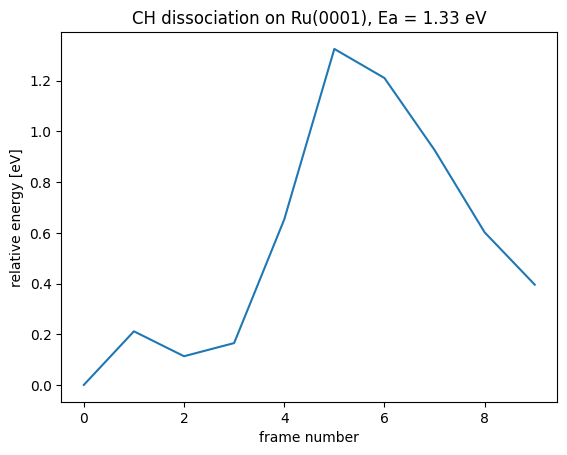

In [15]:
# Plot the reaction coordinate

es = [e - es[0] for e in es]
plt.plot(es)
plt.xlabel("frame number")
plt.ylabel("relative energy [eV]")
plt.title(f"CH dissociation on Ru(0001), Ea = {max(es):1.2f} eV")
plt.savefig("CH_dissoc_on_Ru_0001.png")

To generalize an interactive visualization, use `ase gui` from the command line or the X3D package

In [ ]:
# Make an interative html file of the optimized neb trajectory
x3d = X3D(optimized_neb)
x3d.write("optimized_neb_ch_disoc_on_Ru0001.html")